In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset
import matplotlib.pyplot as plt
import seaborn as sns
from collections import OrderedDict
import copy
import time
from scipy import stats
from scipy.stats import ttest_1samp
import pandas as pd
import warnings
from sklearn.datasets import fetch_california_housing, load_diabetes
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error

In [2]:
import random

def set_seed(seed):
    """Set seeds for reproducibility."""
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    np.random.seed(seed)
    random.seed(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

warnings.filterwarnings('ignore')
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [3]:
class LayerAnalysisRegressor(nn.Module):
    """
    Feedforward neural network for regression with multiple layers for compression analysis.
    """
    def __init__(self, input_dim, output_dim=1):
        super(LayerAnalysisRegressor, self).__init__()

        self.fc1 = nn.Linear(input_dim, 256)
        self.fc2 = nn.Linear(256, 128)
        self.fc3 = nn.Linear(128, 64)
        self.fc4 = nn.Linear(64, 32)
        self.fc5 = nn.Linear(32, output_dim)

        self.dropout = nn.Dropout(0.3)

        self.layer_info = OrderedDict([
            ('fc1', {'layer': self.fc1, 'type': 'fc', 'position': 'early'}),
            ('fc2', {'layer': self.fc2, 'type': 'fc', 'position': 'early'}),
            ('fc3', {'layer': self.fc3, 'type': 'fc', 'position': 'middle'}),
            ('fc4', {'layer': self.fc4, 'type': 'fc', 'position': 'middle'}),
            ('fc5', {'layer': self.fc5, 'type': 'fc', 'position': 'final'})
        ])

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = F.relu(self.fc2(x))
        x = self.dropout(x)
        x = F.relu(self.fc3(x))
        x = self.dropout(x)
        x = F.relu(self.fc4(x))
        x = self.fc5(x)
        return x

In [4]:
def algorithm_11_randomized_svd_power_iteration(A, k, q=2):
    """Randomized SVD with power iteration."""
    m, n = A.shape
    Omega = np.random.randn(n, 2 * k)
    Y = A @ Omega
    for _ in range(q):
        Y = A @ (A.T @ Y)
    Q, R = np.linalg.qr(Y)
    B = Q.T @ A
    U_tilde, Sigma, Vt = np.linalg.svd(B, full_matrices=False)
    U = Q @ U_tilde
    rank = min(k, len(Sigma))
    U = U[:, :rank]
    Sigma = Sigma[:rank]
    Vt = Vt[:rank, :]
    return U, Sigma, Vt

def linear_to_matrix(weight):
    """Converts a linear layer's weight tensor to its 2D matrix form."""
    return weight.cpu().numpy()

def calculate_total_parameters(model):
    """Calculates the total number of trainable parameters in a PyTorch model."""
    return sum(p.numel() for p in model.parameters())

def comprehensive_evaluate_model(model, dataloader, scaler_y=None):
    """
    Comprehensive model evaluation with multiple metrics.
    """
    model.eval()
    all_predictions = []
    all_targets = []

    with torch.no_grad():
        for inputs, targets in dataloader:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            all_predictions.extend(outputs.squeeze().cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    # Convert to numpy arrays
    all_predictions = np.array(all_predictions)
    all_targets = np.array(all_targets)

    # If targets were standardized, inverse transform for evaluation
    if scaler_y is not None:
        all_predictions = scaler_y.inverse_transform(all_predictions.reshape(-1, 1)).flatten()
        all_targets = scaler_y.inverse_transform(all_targets.reshape(-1, 1)).flatten()

    r2 = r2_score(all_targets, all_predictions)
    rmse = np.sqrt(mean_squared_error(all_targets, all_predictions))
    mae = mean_absolute_error(all_targets, all_predictions)

    return {
        'r2': r2,
        'rmse': rmse,
        'mae': mae,
        'predictions': all_predictions,
        'targets': all_targets
    }

In [5]:
def train_model(model, trainloader, valloader, epochs=50, lr=0.001, patience=10, scaler_y=None):
    """
    Train regression model with early stopping and comprehensive evaluation.
    """
    model.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_r2 = -float('inf')
    patience_counter = 0
    best_model_state = None
    training_history = {'train_loss': [], 'val_r2': [], 'val_rmse': []}

    for epoch in range(epochs):
        # Training phase
        model.train()
        epoch_loss = 0
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()
            epoch_loss += loss.item()

        # Validation phase
        val_metrics = comprehensive_evaluate_model(model, valloader, scaler_y)
        val_r2 = val_metrics['r2']

        # Store history
        training_history['train_loss'].append(epoch_loss / len(trainloader))
        training_history['val_r2'].append(val_r2)
        training_history['val_rmse'].append(val_metrics['rmse'])

        # Early stopping check
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        # Print progress
        if epoch % 10 == 0:
            print(f"Epoch {epoch:3d}: Train Loss={epoch_loss/len(trainloader):.4f}, "
                  f"Val R²={val_r2:.4f}, Val RMSE={val_metrics['rmse']:.4f}")

        # Early stopping
        if patience_counter >= patience:
            print(f"Early stopping at epoch {epoch}! No improvement for {patience} epochs.")
            break

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model, best_val_r2, training_history

In [6]:
def fine_tune_compressed_model(model, trainloader, valloader, epochs=10, lr=0.0001, patience=5, scaler_y=None):
    """Fine-tune compressed regression model."""
    model.train()
    criterion = nn.MSELoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    best_val_r2 = -float('inf')
    patience_counter = 0
    best_model_state = None

    for epoch in range(epochs):
        # Training phase
        for inputs, targets in trainloader:
            inputs, targets = inputs.to(device), targets.to(device)

            optimizer.zero_grad()
            outputs = model(inputs)
            loss = criterion(outputs.squeeze(), targets)
            loss.backward()
            optimizer.step()

        # Validation phase
        val_metrics = comprehensive_evaluate_model(model, valloader, scaler_y)
        val_r2 = val_metrics['r2']

        # Early stopping check
        if val_r2 > best_val_r2:
            best_val_r2 = val_r2
            patience_counter = 0
            best_model_state = copy.deepcopy(model.state_dict())
        else:
            patience_counter += 1

        # Early stopping
        if patience_counter >= patience:
            break

    # Load best model state
    if best_model_state is not None:
        model.load_state_dict(best_model_state)

    return model

In [7]:
class CompressedLinear(nn.Module):
    """Compressed Linear layer using low-rank decomposition (SVD)."""
    def __init__(self, U, S, Vt, original_shape, bias=None):
        super(CompressedLinear, self).__init__()

        out_features, in_features = original_shape
        rank = len(S)

        self.original_shape = original_shape
        self.rank = rank

        self.linear1 = nn.Linear(in_features, rank, bias=False)
        self.linear2 = nn.Linear(rank, out_features, bias=bias is not None)

        self._initialize_from_svd(U, S, Vt)

        if bias is not None:
            self.linear2.bias.data = bias

    def _initialize_from_svd(self, U, S, Vt):
        """Initialize weights using SVD components."""
        self.linear1.weight.data = torch.from_numpy(Vt).float()
        US = U @ np.diag(S)
        self.linear2.weight.data = torch.from_numpy(US).float()

    def forward(self, x):
        """Forward pass through compressed linear layer."""
        x = self.linear1(x)
        x = self.linear2(x)
        return x

In [8]:
def get_optimal_rank(singular_values, energy_retention, min_rank=1):
    """
    More robust SVD rank selection with better error handling.
    """
    if not 0.0 < energy_retention <= 1.0:
        raise ValueError(f"Energy retention must be in (0,1], got {energy_retention}")

    total_energy = np.sum(singular_values**2)
    cumsum_energy = np.cumsum(singular_values**2)
    energy_ratios = cumsum_energy / total_energy

    # Find first rank that meets energy requirement
    valid_ranks = np.where(energy_ratios >= energy_retention)[0]
    if len(valid_ranks) == 0:
        print(f"Warning: Energy retention {energy_retention} too high, using full rank")
        return len(singular_values)

    optimal_rank = valid_ranks[0] + 1
    return max(min_rank, min(optimal_rank, len(singular_values)))

def validate_compression_inputs(model, spectrum_analysis, energy_retention):
    """Validate inputs before compression."""
    if not 0.0 < energy_retention <= 1.0:
        raise ValueError(f"Energy retention must be in (0,1], got {energy_retention}")

    for layer_name in model.layer_info.keys():
        if layer_name not in spectrum_analysis:
            raise ValueError(f"Missing spectrum analysis for layer {layer_name}")

    return True

def compress_single_layer(model, layer_name, energy_retention, spectrum_analysis):
    """Compresses a single layer to specified energy retention level."""
    validate_compression_inputs(model, spectrum_analysis, energy_retention)

    device = next(model.parameters()).device
    layer = getattr(model, layer_name)
    weight = layer.weight.data
    original_shape = weight.shape

    # Convert weight to matrix form
    W_matrix = linear_to_matrix(weight)

    # Determine rank based on energy retention
    if layer_name in spectrum_analysis:
        singular_values = spectrum_analysis[layer_name]['singular_values']
        rank = get_optimal_rank(singular_values, energy_retention)
    else:
        # Fallback: compute SVD on the fly
        _, S_full, _ = np.linalg.svd(W_matrix, full_matrices=False)
        rank = get_optimal_rank(S_full, energy_retention)

    # Apply SVD compression
    try:
        U, S, Vt = algorithm_11_randomized_svd_power_iteration(W_matrix, rank, q=2)
    except Exception as e:
        print(f"SVD failed for {layer_name}, using numpy SVD fallback")
        U, S, Vt = np.linalg.svd(W_matrix, full_matrices=False)
        U, S, Vt = U[:, :rank], S[:rank], Vt[:rank, :]

    bias = layer.bias.data if layer.bias is not None else None

    # Create compressed layer
    compressed_layer = CompressedLinear(U, S, Vt, original_shape, bias)
    compressed_layer = compressed_layer.to(device)
    setattr(model, layer_name, compressed_layer)

    return model

In [9]:
def load_regression_dataset(dataset_name='california', batch_size=64, standardize_targets=False):
    """
    Load regression datasets with improved target handling.
    """
    if dataset_name == 'california':
        data = fetch_california_housing()
    elif dataset_name == 'diabetes':
        data = load_diabetes()
    else:
        raise ValueError("Dataset must be 'california' or 'diabetes'")

    X, y = data.data, data.target

    # Always standardize features
    scaler_X = StandardScaler()
    X_scaled = scaler_X.fit_transform(X)

    # Optionally standardize targets
    scaler_y = None
    if standardize_targets:
        scaler_y = StandardScaler()
        y_scaled = scaler_y.fit_transform(y.reshape(-1, 1)).flatten()
    else:
        y_scaled = y

    # Train/val/test split
    X_train, X_temp, y_train, y_temp = train_test_split(X_scaled, y_scaled, test_size=0.3, random_state=42)
    X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42)

    # Create DataLoaders
    train_dataset = TensorDataset(torch.FloatTensor(X_train), torch.FloatTensor(y_train))
    val_dataset = TensorDataset(torch.FloatTensor(X_val), torch.FloatTensor(y_val))
    test_dataset = TensorDataset(torch.FloatTensor(X_test), torch.FloatTensor(y_test))

    dataloaders = (
        DataLoader(train_dataset, batch_size=batch_size, shuffle=True),
        DataLoader(val_dataset, batch_size=batch_size, shuffle=False),
        DataLoader(test_dataset, batch_size=batch_size, shuffle=False)
    )

    return dataloaders, scaler_X, scaler_y

In [10]:
def analyze_singular_value_spectrum(model, save_plots=True):
    """Analyzes the singular value spectrum for each layer."""
    spectrum_analysis = {}

    if save_plots:
        fig, axes = plt.subplots(1, len(model.layer_info), figsize=(20, 4))
        if len(model.layer_info) == 1:
            axes = [axes]
        plot_idx = 0

    for layer_name, info in model.layer_info.items():
        layer = info['layer']
        weight = layer.weight.data

        # Convert to matrix form for SVD
        W_matrix = linear_to_matrix(weight)

        # Compute full SVD
        _, S, _ = np.linalg.svd(W_matrix, full_matrices=False)

        # Normalize singular values
        S_normalized = S / S[0] if len(S) > 0 else S

        # Calculate energy retention curve
        energy_cumsum = np.cumsum(S**2) / np.sum(S**2) if np.sum(S**2) > 0 else np.zeros_like(S)

        # Analyze decay characteristics
        ranks_for_energy = {}
        for energy_level in [0.8, 0.85, 0.9, 0.95, 0.99]:
            rank = get_optimal_rank(S, energy_level)
            ranks_for_energy[energy_level] = rank

        # Calculate decay rate with better error handling
        if len(S) >= 2:
            n_fit = min(max(3, len(S) // 3), len(S))
            log_s = np.log(S_normalized[:n_fit] + 1e-10)
            indices = np.arange(len(log_s))

            if len(indices) >= 2:
                decay_rate = -np.polyfit(indices, log_s, 1)[0]
            else:
                decay_rate = -np.log(S_normalized[1] / S_normalized[0]) if len(S) > 1 else 0.0
        else:
            decay_rate = 0.0

        spectrum_analysis[layer_name] = {
            'singular_values': S,
            'energy_cumsum': energy_cumsum,
            'ranks_for_energy': ranks_for_energy,
            'decay_rate': decay_rate,
            'effective_rank': np.sum(S > 0.01 * S[0]) if len(S) > 0 else 0,
            'layer_type': info['type'],
            'layer_position': info['position']
        }

        # Plot spectrum if requested
        if save_plots and plot_idx < len(axes):
            ax = axes[plot_idx]
            ax.semilogy(S_normalized, 'b-', linewidth=2)
            ax.set_title(f'{layer_name} - Decay Rate: {decay_rate:.3f}')
            ax.set_xlabel('Singular Value Index')
            ax.set_ylabel('Normalized Singular Value')
            ax.grid(True, alpha=0.3)
            plot_idx += 1

    if save_plots:
        plt.tight_layout()
        plt.savefig('singular_value_spectra_regression.png', dpi=300, bbox_inches='tight')
        plt.show()

    return spectrum_analysis

In [11]:
def find_optimal_layer_compression(model, layer_name, spectrum_analysis, trainloader, valloader,
                                 min_r2, scaler_y=None, min_retention=0.30, max_retention=0.99):
    """Find optimal compression for a layer based on R² score."""
    print(f"  Finding optimal compression for {layer_name}...")

    # Coarse search with more granular steps
    coarse_retentions = np.arange(max_retention, min_retention - 0.05, -0.05)
    feasible_retentions = []

    for retention in coarse_retentions:
        test_model = copy.deepcopy(model)
        try:
            test_model = compress_single_layer(test_model, layer_name, retention, spectrum_analysis)
        except Exception as e:
            print(f"    Compression failed at retention {retention:.2f}: {e}")
            continue

        # Fine-tune
        fine_tune_compressed_model(test_model, trainloader, valloader,
                                 epochs=5, lr=0.0001, patience=3, scaler_y=scaler_y)

        # Evaluate on validation set
        val_metrics = comprehensive_evaluate_model(test_model, valloader, scaler_y)
        final_r2 = val_metrics['r2']

        # Calculate compression ratio
        original_layer = getattr(model, layer_name)
        compressed_layer = getattr(test_model, layer_name)
        original_params = original_layer.weight.numel()
        if hasattr(compressed_layer, 'rank'):
            # For compressed layers
            compressed_params = calculate_total_parameters(compressed_layer)
        else:
            compressed_params = original_params
        compression_ratio = original_params / compressed_params if compressed_params > 0 else 1.0

        print(f"    Retention {retention:.2f}: R² {final_r2:.4f}, Ratio {compression_ratio:.2f}x")

        if final_r2 >= min_r2:
            feasible_retentions.append((retention, final_r2, compression_ratio))

    if not feasible_retentions:
        print(f"    No feasible compression found for {layer_name}, using {max_retention} retention")
        return max_retention, comprehensive_evaluate_model(model, valloader, scaler_y)['r2'], 1.0

    # Find the most aggressive compression that still meets R² requirement
    best_retention = min(feasible_retentions, key=lambda x: x[0])

    return best_retention[0], best_retention[1], best_retention[2]

In [12]:
def adaptive_iterative_compression(model, spectrum_analysis, trainloader, valloader,
                                 max_r2_drop=0.02, scaler_y=None):
    """Enhanced adaptive compression with timing and better error handling."""
    start_time = time.time()

    print(f"\n{'='*60}")
    print(f"ADAPTIVE COMPRESSION - Max R² Drop: {max_r2_drop:.3f}")
    print(f"{'='*60}")

    # Get original validation metrics
    original_metrics = comprehensive_evaluate_model(model, valloader, scaler_y)
    original_r2 = original_metrics['r2']
    min_r2 = original_r2 - max_r2_drop

    print(f"Original validation R²: {original_r2:.4f}")
    print(f"Original validation RMSE: {original_metrics['rmse']:.4f}")
    print(f"Minimum acceptable R²: {min_r2:.4f}")

    # Work on a copy of the model
    compressed_model = copy.deepcopy(model)

    # Define compression strategy based on R² drop threshold
    if max_r2_drop <= 0.01:
        layer_targets = {
            'fc2': (0.90, 0.98),
            'fc3': (0.85, 0.95),
            'fc4': (0.80, 0.92)
        }
        print("Using CONSERVATIVE compression strategy")
    elif max_r2_drop <= 0.03:
        layer_targets = {
            'fc2': (0.75, 0.90),
            'fc3': (0.70, 0.85),
            'fc4': (0.65, 0.80)
        }
        print("Using MODERATE compression strategy")
    elif max_r2_drop <= 0.06:
        layer_targets = {
            'fc2': (0.60, 0.80),
            'fc3': (0.55, 0.75),
            'fc4': (0.50, 0.70)
        }
        print("Using AGGRESSIVE compression strategy")
    else:
        layer_targets = {
            'fc2': (0.45, 0.70),
            'fc3': (0.40, 0.65),
            'fc4': (0.35, 0.60)
        }
        print("Using VERY AGGRESSIVE compression strategy")

    # Apply fixed compressions first
    print(f"\nApplying fixed compressions:")

    # Compress fc1 with 95% energy retention
    compressed_model = compress_single_layer(compressed_model, 'fc1', 0.95, spectrum_analysis)
    print(f"  fc1 compressed with 95% energy retention")

    # Compress fc5 with 90% energy retention
    compressed_model = compress_single_layer(compressed_model, 'fc5', 0.90, spectrum_analysis)
    print(f"  fc5 compressed with 90% energy retention")

    # Fine-tune after fixed compressions
    print(f"  Fine-tuning model after fixed compressions...")
    fine_tune_compressed_model(compressed_model, trainloader, valloader,
                             epochs=5, lr=0.0001, patience=3, scaler_y=scaler_y)

    current_metrics = comprehensive_evaluate_model(compressed_model, valloader, scaler_y)
    current_r2 = current_metrics['r2']
    print(f"  R² after fixed compressions: {current_r2:.4f}")

    # Calculate compression ratios for fixed layers
    fc1_original = getattr(model, 'fc1')
    fc1_compressed = getattr(compressed_model, 'fc1')
    fc1_ratio = fc1_original.weight.numel() / calculate_total_parameters(fc1_compressed)

    fc5_original = getattr(model, 'fc5')
    fc5_compressed = getattr(compressed_model, 'fc5')
    fc5_ratio = fc5_original.weight.numel() / calculate_total_parameters(fc5_compressed)

    # Initialize layer_results with fixed compressions
    layer_results = {
        'fc1': {'energy_retention': 0.95, 'r2': current_r2, 'compression_ratio': fc1_ratio},
        'fc5': {'energy_retention': 0.90, 'r2': current_r2, 'compression_ratio': fc5_ratio}
    }

    # Continue adaptive compression for remaining layers
    layer_order = ['fc4', 'fc3', 'fc2']

    for layer_name in layer_order:
        if layer_name not in layer_targets:
            continue

        print(f"\nCompressing {layer_name}...")
        print(f"  Current model validation R²: {current_r2:.4f}")

        min_ret, max_ret = layer_targets[layer_name]

        # Find optimal compression for this layer
        try:
            retention, r2, ratio = find_optimal_layer_compression(
                compressed_model, layer_name, spectrum_analysis, trainloader, valloader,
                min_r2, scaler_y=scaler_y, min_retention=min_ret, max_retention=max_ret
            )
        except Exception as e:
            print(f"  Error compressing {layer_name}: {e}")
            retention, r2, ratio = max_ret, current_r2, 1.0

        # Apply compression
        compressed_model = compress_single_layer(compressed_model, layer_name, retention, spectrum_analysis)

        # Fine-tune the entire model after compression
        print(f"  Fine-tuning model after {layer_name} compression...")
        fine_tune_compressed_model(compressed_model, trainloader, valloader,
                                 epochs=8, lr=0.0001, patience=4, scaler_y=scaler_y)

        # Evaluate on validation set
        final_metrics = comprehensive_evaluate_model(compressed_model, valloader, scaler_y)
        final_r2 = final_metrics['r2']

        layer_results[layer_name] = {
            'energy_retention': retention,
            'r2': final_r2,
            'compression_ratio': ratio
        }

        current_r2 = final_r2
        print(f"  {layer_name}: {retention:.3f} energy, {final_r2:.4f} val R², {ratio:.2f}x compression")

        # Early stop if we're getting too close to the minimum R²
        if final_r2 < min_r2 + 0.005:
            print(f"  Approaching minimum R² threshold, stopping compression")
            break

    # Calculate overall compression ratio and final metrics
    total_original_params = calculate_total_parameters(model)
    total_compressed_params = calculate_total_parameters(compressed_model)
    overall_compression_ratio = total_original_params / total_compressed_params

    final_metrics = comprehensive_evaluate_model(compressed_model, valloader, scaler_y)
    compression_time = time.time() - start_time

    print(f"\n{'='*40}")
    print(f"FINAL RESULTS (Validation Set):")
    print(f"Original parameters: {total_original_params:,}")
    print(f"Compressed parameters: {total_compressed_params:,}")
    print(f"Overall compression ratio: {overall_compression_ratio:.2f}x")
    print(f"Final validation R²: {final_metrics['r2']:.4f}")
    print(f"Final validation RMSE: {final_metrics['rmse']:.4f}")
    print(f"Validation R² drop: {original_r2 - final_metrics['r2']:.4f}")
    print(f"Compression time: {compression_time:.2f} seconds")
    print(f"{'='*40}")

    return {
        'model': compressed_model,
        'original_r2': original_r2,
        'final_r2': final_metrics['r2'],
        'original_rmse': original_metrics['rmse'],
        'final_rmse': final_metrics['rmse'],
        'r2_drop': original_r2 - final_metrics['r2'],
        'overall_compression_ratio': overall_compression_ratio,
        'total_original_params': total_original_params,
        'total_compressed_params': total_compressed_params,
        'layer_results': layer_results,
        'compression_time': compression_time
    }

In [13]:
def compare_compression_levels(results_list, baseline_metrics):
    """Compare compression levels with statistical tests."""
    for i, result in enumerate(results_list):
        if 'r2_values' in result and len(result['r2_values']) > 1:
            # Test if significantly different from baseline
            t_stat, p_value = ttest_1samp(result['r2_values'], baseline_metrics['r2'])
            result['significance'] = p_value < 0.05
            result['p_value'] = p_value
            result['significantly_worse'] = (p_value < 0.05) and (np.mean(result['r2_values']) < baseline_metrics['r2'])
        else:
            result['significance'] = False
            result['p_value'] = 1.0
            result['significantly_worse'] = False

In [14]:
def plot_enhanced_compression_curves(results_summary):
    """Enhanced plotting with multiple metrics and statistical information."""

    # Extract data
    r2_drops = [r['r2_drop'] for r in results_summary]
    compression_ratios = [r['overall_compression_ratio'] for r in results_summary]
    final_r2_scores = [r['final_r2'] for r in results_summary]
    rmse_values = [r['final_rmse'] for r in results_summary]

    # Create subplots
    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(15, 12))

    # Plot 1: R² Drop vs Compression Ratio
    ax1.scatter(compression_ratios, r2_drops, c='red', s=100, alpha=0.7, edgecolors='black')
    ax1.set_xlabel('Compression Ratio')
    ax1.set_ylabel('R² Drop')
    ax1.set_title('R² Drop vs Compression Ratio')
    ax1.grid(True, alpha=0.3)

    # Add trend line
    if len(compression_ratios) > 1:
        z = np.polyfit(compression_ratios, r2_drops, 1)
        p = np.poly1d(z)
        ax1.plot(sorted(compression_ratios), p(sorted(compression_ratios)), "r--", alpha=0.8)

    # Plot 2: Final R² vs Compression Ratio
    ax2.scatter(compression_ratios, final_r2_scores, c='blue', s=100, alpha=0.7, edgecolors='black')
    ax2.set_xlabel('Compression Ratio')
    ax2.set_ylabel('Final R²')
    ax2.set_title('Final R² vs Compression Ratio')
    ax2.grid(True, alpha=0.3)

    # Plot 3: RMSE vs Compression Ratio
    ax3.scatter(compression_ratios, rmse_values, c='green', s=100, alpha=0.7, edgecolors='black')
    ax3.set_xlabel('Compression Ratio')
    ax3.set_ylabel('Final RMSE')
    ax3.set_title('Final RMSE vs Compression Ratio')
    ax3.grid(True, alpha=0.3)

    # Plot 4: Pareto frontier (R² vs Compression)
    ax4.scatter(final_r2_scores, compression_ratios, c='purple', s=100, alpha=0.7, edgecolors='black')
    ax4.set_xlabel('Final R²')
    ax4.set_ylabel('Compression Ratio')
    ax4.set_title('Pareto Frontier: R² vs Compression')
    ax4.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.savefig('compression_analysis_regression.png', dpi=300, bbox_inches='tight')
    plt.show()

In [15]:
def run_comprehensive_compression_study(dataset_name='california', n_trials=3,
                                      standardize_targets=False, seed=42):
    """
    Run comprehensive compression study with multiple trials and statistical analysis.
    """
    set_seed(seed)

    print(f"\n{'='*80}")
    print(f"COMPREHENSIVE COMPRESSION STUDY")
    print(f"Dataset: {dataset_name}")
    print(f"Trials per compression level: {n_trials}")
    print(f"Standardize targets: {standardize_targets}")
    print(f"{'='*80}")

    # Load dataset
    dataloaders, scaler_X, scaler_y = load_regression_dataset(
        dataset_name=dataset_name,
        batch_size=64,
        standardize_targets=standardize_targets
    )
    trainloader, valloader, testloader = dataloaders

    # Get input dimension from the first batch
    sample_batch = next(iter(trainloader))
    input_dim = sample_batch[0].shape[1]

    # Train baseline model
    print("\n" + "="*50)
    print("TRAINING BASELINE MODEL")
    print("="*50)

    baseline_model = LayerAnalysisRegressor(input_dim)
    baseline_model, _, training_history = train_model(
        baseline_model, trainloader, valloader, epochs=100, lr=0.001,
        patience=15, scaler_y=scaler_y
    )

    # Evaluate baseline
    baseline_metrics = comprehensive_evaluate_model(baseline_model, testloader, scaler_y)
    print(f"\nBaseline Test Performance:")
    print(f"R²: {baseline_metrics['r2']:.4f}")
    print(f"RMSE: {baseline_metrics['rmse']:.4f}")
    print(f"MAE: {baseline_metrics['mae']:.4f}")

    # Analyze singular value spectrum
    print("\n" + "="*50)
    print("ANALYZING SINGULAR VALUE SPECTRUM")
    print("="*50)

    spectrum_analysis = analyze_singular_value_spectrum(baseline_model, save_plots=True)

    # Print spectrum analysis summary
    print("\nSpectrum Analysis Summary:")
    for layer_name, analysis in spectrum_analysis.items():
        print(f"{layer_name}:")
        print(f"  Decay rate: {analysis['decay_rate']:.3f}")
        print(f"  Effective rank: {analysis['effective_rank']}")
        print(f"  Ranks for energy retention:")
        for energy, rank in analysis['ranks_for_energy'].items():
            print(f"    {energy*100:.0f}%: {rank}")

    # Define compression levels to test
    compression_levels = [0.00, 0.02, 0.03, 0.05, 0.08]

    results_summary = []

    # Test different compression levels
    for max_r2_drop in compression_levels:
        print(f"\n{'='*60}")
        print(f"TESTING COMPRESSION WITH MAX R² DROP: {max_r2_drop:.3f}")
        print(f"{'='*60}")

        level_results = {
            'max_r2_drop': max_r2_drop,
            'r2_values': [],
            'rmse_values': [],
            'compression_ratios': [],
            'compression_times': []
        }

        for trial in range(n_trials):
            print(f"\n--- Trial {trial + 1}/{n_trials} ---")

            # Create fresh model copy for each trial
            trial_model = copy.deepcopy(baseline_model)

            # Run adaptive compression
            compression_result = adaptive_iterative_compression(
                trial_model, spectrum_analysis, trainloader, valloader,
                max_r2_drop=max_r2_drop, scaler_y=scaler_y
            )

            # Evaluate on test set
            test_metrics = comprehensive_evaluate_model(
                compression_result['model'], testloader, scaler_y
            )

            # Store results
            level_results['r2_values'].append(test_metrics['r2'])
            level_results['rmse_values'].append(test_metrics['rmse'])
            level_results['compression_ratios'].append(compression_result['overall_compression_ratio'])
            level_results['compression_times'].append(compression_result['compression_time'])

            print(f"Trial {trial + 1} Test R²: {test_metrics['r2']:.4f}")
            print(f"Trial {trial + 1} Compression Ratio: {compression_result['overall_compression_ratio']:.2f}x")

        # Calculate statistics for this compression level
        level_results['mean_r2'] = np.mean(level_results['r2_values'])
        level_results['std_r2'] = np.std(level_results['r2_values'])
        level_results['mean_rmse'] = np.mean(level_results['rmse_values'])
        level_results['std_rmse'] = np.std(level_results['rmse_values'])
        level_results['mean_compression_ratio'] = np.mean(level_results['compression_ratios'])
        level_results['std_compression_ratio'] = np.std(level_results['compression_ratios'])
        level_results['mean_compression_time'] = np.mean(level_results['compression_times'])

        # Calculate R² drop from baseline
        level_results['r2_drop'] = baseline_metrics['r2'] - level_results['mean_r2']
        level_results['final_r2'] = level_results['mean_r2']
        level_results['final_rmse'] = level_results['mean_rmse']
        level_results['overall_compression_ratio'] = level_results['mean_compression_ratio']

        results_summary.append(level_results)

        print(f"\nLevel Summary (Max R² Drop: {max_r2_drop:.3f}):")
        print(f"Mean Test R²: {level_results['mean_r2']:.4f} ± {level_results['std_r2']:.4f}")
        print(f"Mean Test RMSE: {level_results['mean_rmse']:.4f} ± {level_results['std_rmse']:.4f}")
        print(f"Mean Compression Ratio: {level_results['mean_compression_ratio']:.2f}x ± {level_results['std_compression_ratio']:.2f}")
        print(f"Mean Compression Time: {level_results['mean_compression_time']:.2f}s")

    # Statistical comparison
    compare_compression_levels(results_summary, baseline_metrics)

    # Create comprehensive results table
    print(f"\n{'='*100}")
    print(f"COMPREHENSIVE RESULTS SUMMARY")
    print(f"{'='*100}")

    print(f"{'Max R² Drop':<12} {'Mean R²':<10} {'R² Std':<8} {'Mean RMSE':<12} {'Compression':<12} {'Significant?':<12}")
    print(f"{'-'*90}")

    for result in results_summary:
        significance = "Yes*" if result.get('significantly_worse', False) else "No"
        print(f"{result['max_r2_drop']:<12.3f} {result['mean_r2']:<10.4f} {result['std_r2']:<8.4f} "
              f"{result['mean_rmse']:<12.4f} {result['mean_compression_ratio']:<12.2f}x {significance:<12}")

    print(f"\nBaseline (No compression): R² = {baseline_metrics['r2']:.4f}, RMSE = {baseline_metrics['rmse']:.4f}")
    print("* Significantly worse than baseline (p < 0.05)")

    # Plot results
    plot_enhanced_compression_curves(results_summary)

    # Find best compression level (highest compression with no significant performance loss)
    best_compression = None
    for result in reversed(results_summary):  # Start from most aggressive
        if not result.get('significantly_worse', True):
            best_compression = result
            break

    if best_compression:
        print(f"\nRECOMMENDED COMPRESSION LEVEL:")
        print(f"Max R² Drop: {best_compression['max_r2_drop']:.3f}")
        print(f"Compression Ratio: {best_compression['mean_compression_ratio']:.2f}x")
        print(f"Performance: R² = {best_compression['mean_r2']:.4f}, RMSE = {best_compression['mean_rmse']:.4f}")
    else:
        print(f"\nWARNING: All compression levels show significant performance degradation!")

    return {
        'baseline_metrics': baseline_metrics,
        'results_summary': results_summary,
        'spectrum_analysis': spectrum_analysis,
        'best_compression': best_compression,
        'dataset_name': dataset_name,
        'n_trials': n_trials
    }

Starting comprehensive compression study...

COMPREHENSIVE COMPRESSION STUDY
Dataset: california
Trials per compression level: 10
Standardize targets: True

TRAINING BASELINE MODEL
Epoch   0: Train Loss=0.4817, Val R²=0.6445, Val RMSE=0.6805
Epoch  10: Train Loss=0.2588, Val R²=0.7512, Val RMSE=0.5693
Epoch  20: Train Loss=0.2319, Val R²=0.7560, Val RMSE=0.5638
Epoch  30: Train Loss=0.2143, Val R²=0.7707, Val RMSE=0.5466
Epoch  40: Train Loss=0.2067, Val R²=0.7811, Val RMSE=0.5340
Epoch  50: Train Loss=0.2010, Val R²=0.7693, Val RMSE=0.5482
Epoch  60: Train Loss=0.1887, Val R²=0.7904, Val RMSE=0.5225
Epoch  70: Train Loss=0.1866, Val R²=0.7926, Val RMSE=0.5198
Epoch  80: Train Loss=0.1825, Val R²=0.7857, Val RMSE=0.5284
Epoch  90: Train Loss=0.1803, Val R²=0.7869, Val RMSE=0.5269

Baseline Test Performance:
R²: 0.8214
RMSE: 0.4860
MAE: 0.3304

ANALYZING SINGULAR VALUE SPECTRUM


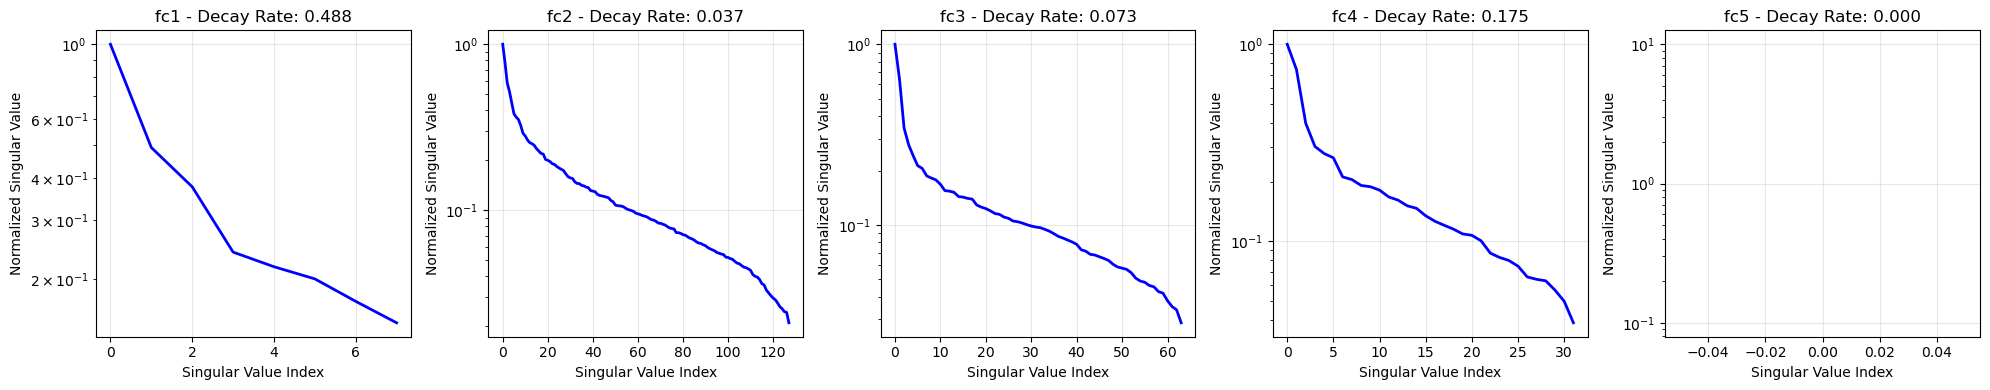


Spectrum Analysis Summary:
fc1:
  Decay rate: 0.488
  Effective rank: 8
  Ranks for energy retention:
    80%: 3
    85%: 3
    90%: 4
    95%: 6
    99%: 8
fc2:
  Decay rate: 0.037
  Effective rank: 128
  Ranks for energy retention:
    80%: 24
    85%: 31
    90%: 43
    95%: 64
    99%: 99
fc3:
  Decay rate: 0.073
  Effective rank: 64
  Ranks for energy retention:
    80%: 11
    85%: 16
    90%: 24
    95%: 35
    99%: 52
fc4:
  Decay rate: 0.175
  Effective rank: 32
  Ranks for energy retention:
    80%: 6
    85%: 8
    90%: 12
    95%: 17
    99%: 26
fc5:
  Decay rate: 0.000
  Effective rank: 1
  Ranks for energy retention:
    80%: 1
    85%: 1
    90%: 1
    95%: 1
    99%: 1

TESTING COMPRESSION WITH MAX R² DROP: 0.000

--- Trial 1/10 ---

ADAPTIVE COMPRESSION - Max R² Drop: 0.000
Original validation R²: 0.7950
Original validation RMSE: 0.5168
Minimum acceptable R²: 0.7950
Using CONSERVATIVE compression strategy

Applying fixed compressions:
  fc1 compressed with 95% energy 

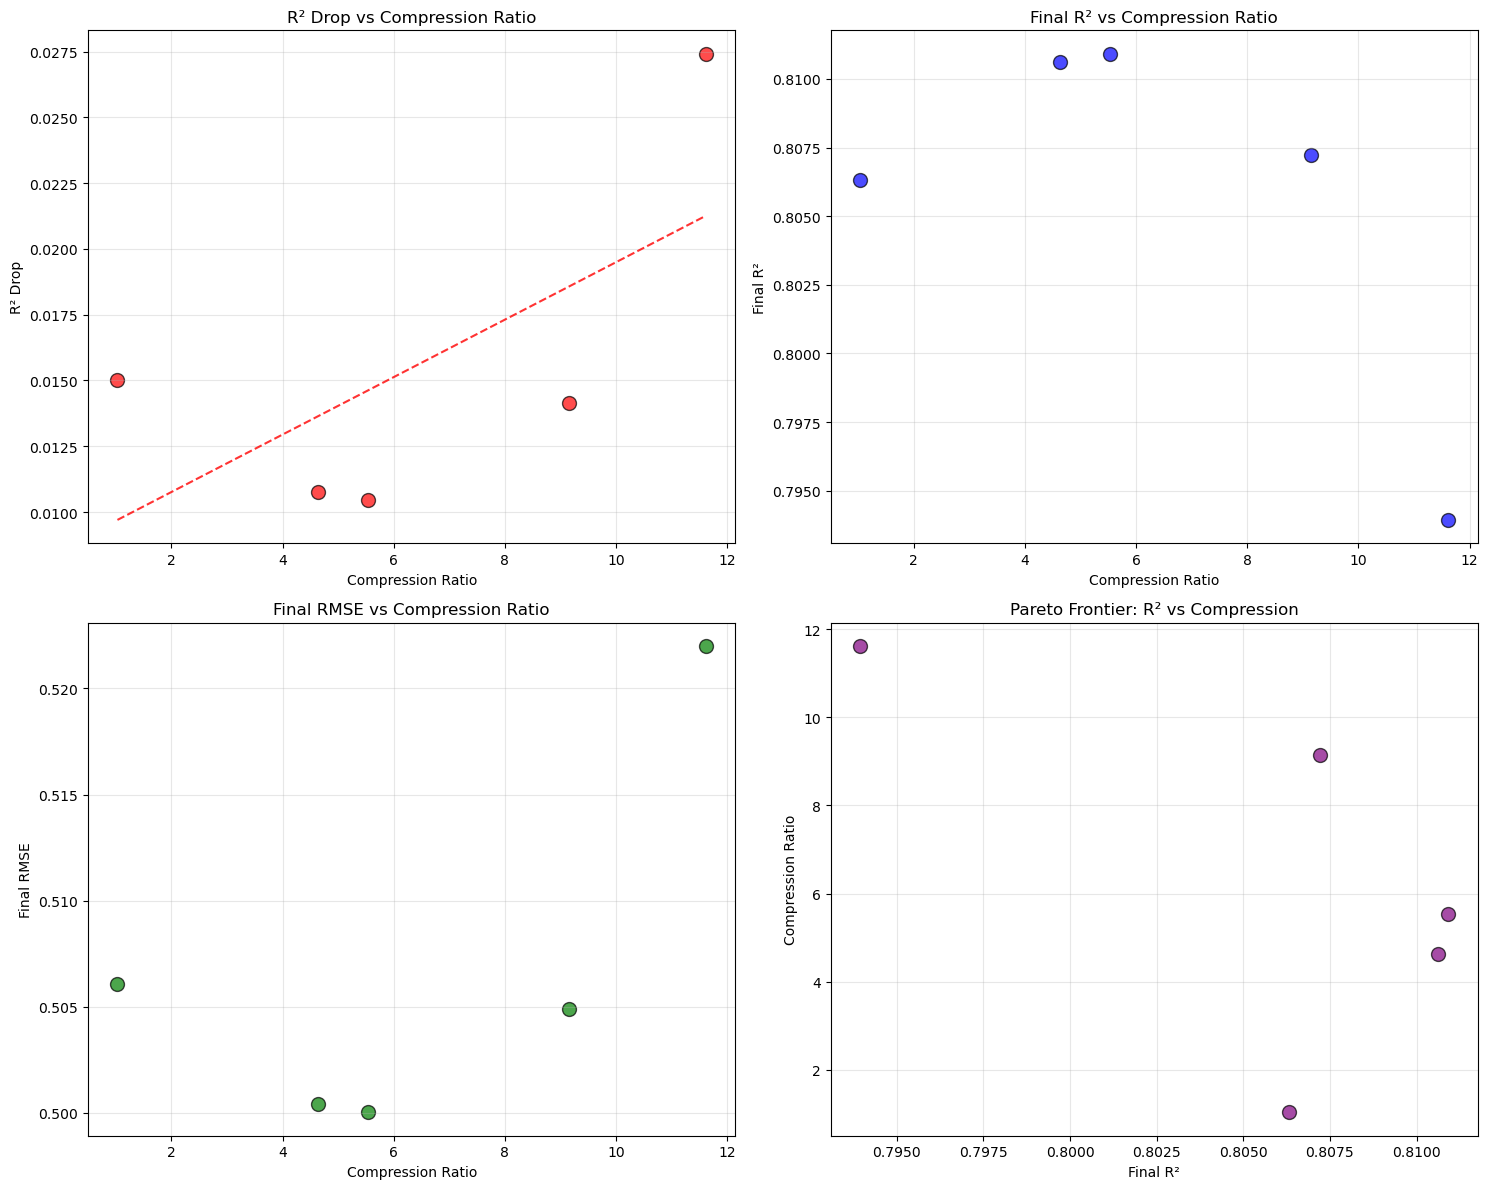



STUDY COMPLETED SUCCESSFULLY!
Results saved to 'compression_study_results.csv'

Script execution completed.


In [16]:
# Main execution
if __name__ == "__main__":
    # Set random seed for reproducibility
    set_seed(42)

    # Run comprehensive study on California housing dataset
    print("Starting comprehensive compression study...")

    try:
        study_results = run_comprehensive_compression_study(
            dataset_name='california',
            n_trials=10,
            standardize_targets=True,
            seed=42
        )

        print("\n" + "="*80)
        print("STUDY COMPLETED SUCCESSFULLY!")
        print("="*80)

        # Save results summary to CSV
        results_df = pd.DataFrame([
            {
                'max_r2_drop': r['max_r2_drop'],
                'mean_r2': r['mean_r2'],
                'std_r2': r['std_r2'],
                'mean_rmse': r['mean_rmse'],
                'std_rmse': r['std_rmse'],
                'mean_compression_ratio': r['mean_compression_ratio'],
                'std_compression_ratio': r['std_compression_ratio'],
                'significantly_worse': r.get('significantly_worse', False),
                'p_value': r.get('p_value', 1.0)
            }
            for r in study_results['results_summary']
        ])

        results_df.to_csv('compression_study_results.csv', index=False)
        print("Results saved to 'compression_study_results.csv'")

    except Exception as e:
        print(f"Study failed with error: {e}")
        import traceback
        traceback.print_exc()

    print("\nScript execution completed.")